## **6. 피마 인디언 당뇨병 예측**

- diabetes.csv를 DataFrame으로 로딩한 후 Outcome 클래스 결정값의 분포와 데이터를 개략적으로 확인

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv(r"C:\Users\이희원\OneDrive\바탕 화면\EWHA\4-1\ESAA\kaggle_data\diabetes.csv")
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- 전체 768개 데이터 중 Negative 값 0이 500 개, Positive 값 1이 268개로 Negative가 상대적으로 많음
- 이제 feature 타입과 Null 개수 살펴보기

In [4]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Null 값은 없으며 피처 타입은 모두 숫자형 => 별도의 피처 인코딩은 필요 X
- 이제 로지스틱 회귀를 이용해 예측 모델 생성  
  => 데이터 세트를 피처 데이터 세트와 클래스 데이터 세트로 나누고 학습 데이터 세트와 테스트 데이터 세트로 분리  
  => 로지스틱 회귀로 예측 수행  
  => 앞 예제에서 사용한 유틸리티 함수인 get_clf_eval(), get_eval_by_threshold(), precision_recall_curve_plot()을 사용해 성능 평가 지표 출력, 재현율 곡선 시각화

In [10]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# get_clf_eval() 정의
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[88 12]
 [23 31]]
정확도 : 0.7727, 정밀도 : 0.7209, 재현율 : 0.5741,     F1 : 0.6392, AUC:0.7919


C:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 전체 데이터의 65% Negative이므로 정확도보다는 재현율 성능에 조금 더 초점 맞춰보자.
- 먼저 정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화 확인
- 이를 위해 precision- 이를 위해 precision_recall_curve

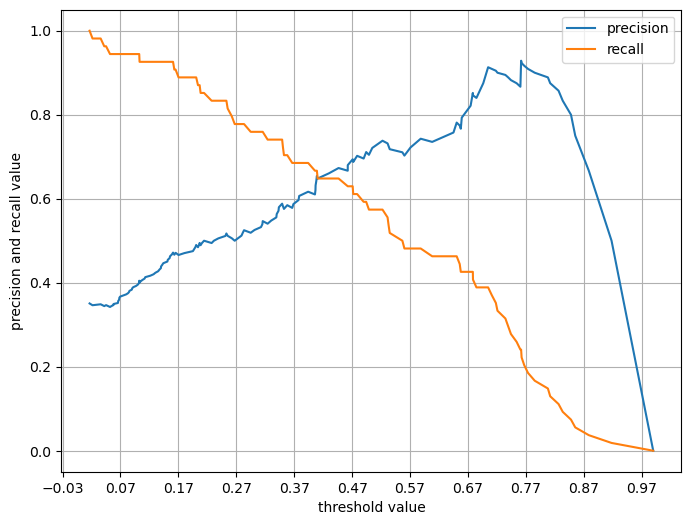

In [13]:
def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율, ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, 
                                                             pred_proba_c1)
    # x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 plot 수행, 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='-',label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 x축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('threshold value'); plt.ylabel('precision and recall value')
    plt.legend(); plt.grid()
    plt.show()

pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

- 임곗값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것으로 보임
- 하지만 두 개의 지표 모두 0.7이 안 되는 수치로, 낮은 값을 가짐
- 따라서 임곗값을 인위적으로 조작하기 전에 다시 데이터 값을 점검하자.
- 원본 데이터 DataFrame의 describe() 메서드 호출해서 피처 값의 분포도 살펴보자

In [15]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


- 위의 데이터 값을 보면 min() 값이 0인 피처가 상당히 많음.
- 예를 들어 Glucose 피처는 포도당 수치인데 min 값이 0인 것은 말이 되지 않음.
- 아래와 같이 Glucose 피처의 히스토그램을 확인해보면 0값이 일정 수준 존재함을 알 수 있음.

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

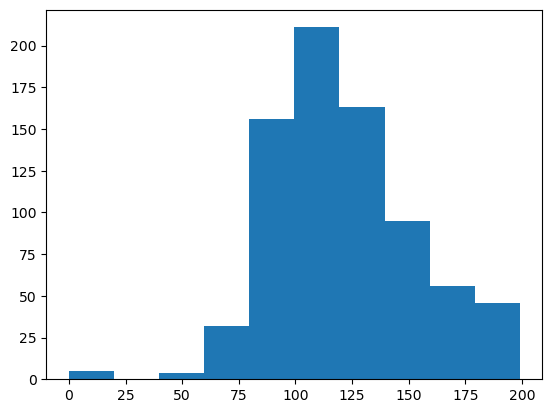

In [16]:
plt.hist(diabetes_data['Glucose'], bins=10)

- min() 값이 0으로 돼 있는 피처에 대해 "0 값의 건수" 및 "전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지" 확인해보자.
- 확인할 피처는 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI' (Pregnancies는 출산 횟수이므로 제외)

In [19]:
# 0 값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


- SkinThickness와 Insulin의 0값은 각각 전체의 29.56%, 48.7%로 대단히 많음.
- 그러나 전체 데이터 건수가 많지 않기 때문에 이들 데이터를 일괄적으로 삭제할 경우 학습을 효과적으로 수행하기 어려울 듯함.
- 따라서 위 피처의 0값을 평균값으로 대체하자.

In [20]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

- 0 값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환하자.
- 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋음.
- 이후에 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용해 성능 평가 지표를 확인하자.

In [23]:
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

#StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111,     F1 : 0.6804, AUC:0.8433


- 데이터 변환과 스케일링을 통해 성능 수치가 일정 수준 개선되었음.
- 하지만 여전히 재현율 수치는 개선이 필요해 보임.
- 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해보자.
- 다음 코드: 임곗값을 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표의 값 변화를 출력
- 임곗값에 따른 평가 수치 출력은 앞에서 사용한 get_eval_by_threshold() 함수 이용

In [25]:
from sklearn.preprocessing import Binarizer
def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # f1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 스코어 print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, f1 : {3:.4f}'.format(accuracy, precision, recall, f1))
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds) :
    # thresholds list 객체 내 값을 차례로 반복하며 평가 수행
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값', custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [26]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도 : 0.7143, 정밀도 : 0.5658, 재현율 : 0.7963, f1 : 0.6615
임곗값 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도 : 0.7403, 정밀도 : 0.6000, 재현율 : 0.7778, f1 : 0.6774
임곗값 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222, f1 : 0.6667
임곗값 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037, f1 : 0.6667
임곗값 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667, f1 : 0.6792
임곗값 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667, f1 : 0.6857
임곗값 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, f1 : 0.6931
임곗값 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, f1 : 0.6804


- 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임곗값은 0.33으로, 재현율 값이 0.7963임.
- 하지만 정밀도가 0.5972로 매우 저조하기 때문에 극단적인 선택으로 보임.
- 임곗값 0.48이 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 좋은 임곗값으로 보임.
- 앞에서 학습된 로지스틱 회귀 모델을 이용해 임곗값을 0.48로 낮춘 상태에서 다시 예측을 해보자.
- 사이킷런의 predict() 메서드는 임곗값을 마음대로 변환할 수 없으므로 별도의 로직으로 이를 구해야 함.
- 앞에서 살펴본 Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률 값을 변환해 변경된 임곗값에 따른 예측 클래스 값을 구해보자.

In [29]:
# get_clf_eval() 정의
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [30]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481,     F1 : 0.6931, AUC:0.8433


## **7. 정리**

- 지금까지 분류에 사용되는 정확도, 오차 행렬, 정밀도, 재현율, F1 스코어, ROC-AUC와 같은 성능 평가 지표를 살펴봄.
- 정확도
  - 특히 이진 분류의 레이블 값이 불균형하게 분포될 경우 (0이 매우 많고 1이 매우 적을 경우 또는 반대의 경우) 단순히 예측 결과와 실제 결과가 일치하는 지표인 정확도만으로는 머신러닝 모델의 예측 성능을 평가할 수 없음.
- 오차 행렬
  - Negative와 Positive 값을 가지는 실제 클래스 값과 예측 클래스 값이 True와 False에 따라 TN, FP, FN, TP로 매핑되는 4분면 행렬을 기반으로 예측 성능 평가
  - 정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP 값을 다양하게 결합해 만들어지며, 이를 통해 분류 모델 예측 성능의 오류가 어떤 모습으로 발생하는지 알 수 있음.
- 정밀도(Precision)와 재현율(Recall)
  - Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
  - 특히 재현율이 상대적으로 더 중요한 지표인 경우는 암 양성 예측 모델과 같이 실제 Positive 양성인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우
  - 분류하려는  업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높이는 방법에 대해 배움.
- F1 스코어
  - 정밀도와 재현율을 결합한 평가 지표
  - 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 높은 값을 가짐
- ROC-AUC
  - 일반적으로 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표
  - AUC (Area Under Curve) 값은 ROC 곡선 밑의 면적을 구한 것으로, 일반적으로 1에 가까울수록 좋은 수치